# Auto-tuning Kalman Filter on a 1D Simulated Trajectory

In [1]:
import numpy as np
np.random.seed(10015)
from matplotlib import pyplot as plt
%matplotlib inline

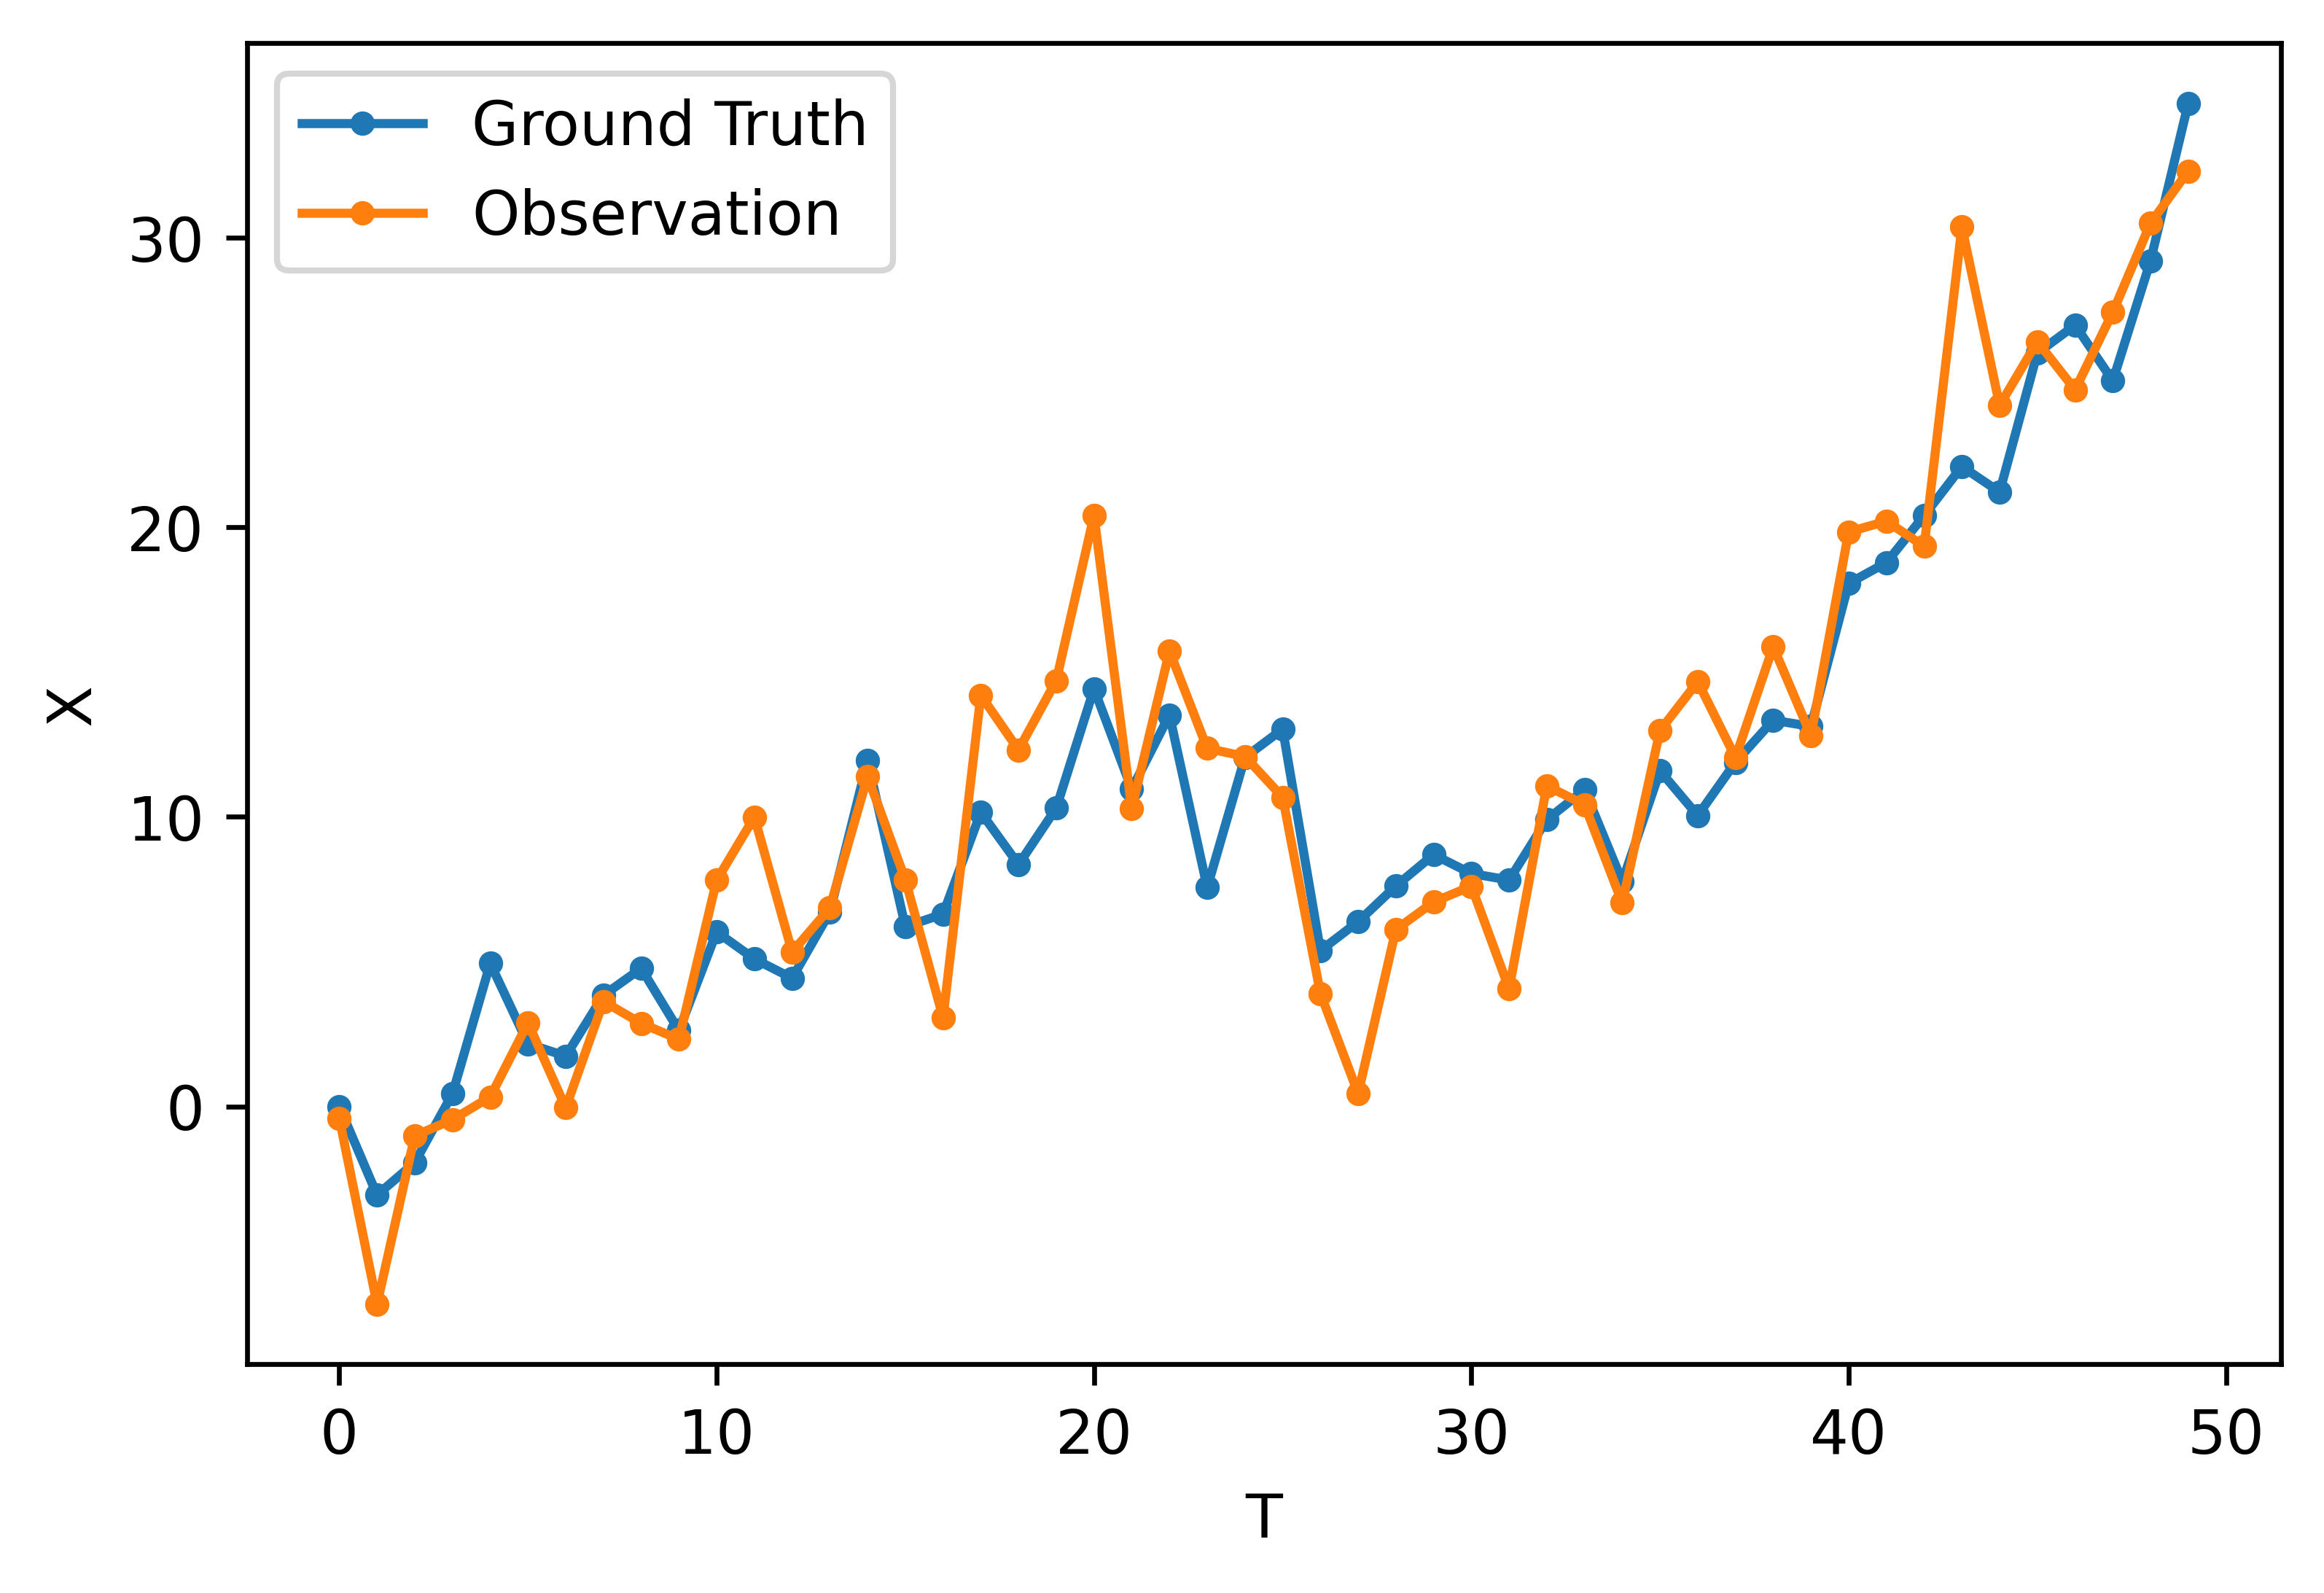

In [2]:
#Simulate a 1D trajectory.
from utils import TrajSimulator1D

traj_simulator = TrajSimulator1D(
    dt=0.01, duration=0.5, initial_state=np.array([[0.0]]), q_var=1000.0, r_var=10.0
)

# gt: ground truth, obs: observation
gt_traj, obs_traj = traj_simulator.simulate()

fig = plt.figure(dpi=600)
plt.plot(gt_traj, marker='.', linestyle='-', label='Ground Truth')
plt.plot(obs_traj, marker='.', linestyle='-', label='Observation')
plt.legend()
plt.xlabel('T');
plt.ylabel('X');

In [3]:
# Build the Kalman filter tuning model
from utils import KalmanFilterTuningModel

# Specify intial P.
P = 1000.0*np.eye(1)
tuning_model = KalmanFilterTuningModel(dim_x=1, dim_z=1, 
                                      F=traj_simulator.F, 
                                      H=traj_simulator.H, 
                                      initial_state=traj_simulator.initial_state, 
                                      P=P, 
                                      observation=obs_traj)

In [4]:
# Build the optimizer
from bayes_opt import BayesianOptimization

def J(q_var, r_var):
    Q = q_var * np.array([[traj_simulator.dt]])
    R = np.array([[r_var]])
    nis_loss = tuning_model.get_filter_nis_loss(Q, R)
    return -nis_loss

pbounds = {
    'q_var': [0, 100], 
    'r_var': [0, 10]
}

optimizer = BayesianOptimization(
    f=J,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
)

In [5]:
# Optimize Q and R for Kalman filter.
optimizer.maximize(
    init_points=5,
    n_iter=100,
)

|   iter    |  target   |   q_var   |   r_var   |
-------------------------------------------------
|  3        | -0.08619  |  91.27    |  8.917    |
|  9        | -0.06087  |  74.28    |  10.0     |
|  11       | -0.01446  |  66.79    |  10.0     |
|  22       | -0.01319  |  62.76    |  9.99     |
|  29       | -0.001112 |  87.57    |  7.92     |
|  34       | -0.000977 |  64.75    |  10.0     |


In [6]:
# Draw the estimated trajectory with best filter parameters.
from filterpy.kalman import KalmanFilter

kalman_filter = KalmanFilter(dim_x=1, dim_z=1)
kalman_filter.F = traj_simulator.F
kalman_filter.H = traj_simulator.H
kalman_filter.x = traj_simulator.initial_state
kalman_filter.P = P

best_q_var = optimizer.max['params']['q_var']
best_r_var = optimizer.max['params']['r_var']
kalman_filter.Q = best_q_var * np.array([[traj_simulator.dt]])
kalman_filter.R = np.array([[best_r_var]])

estimate_traj_mu, estimate_traj_cov, _, _ = kalman_filter.batch_filter(obs_traj)

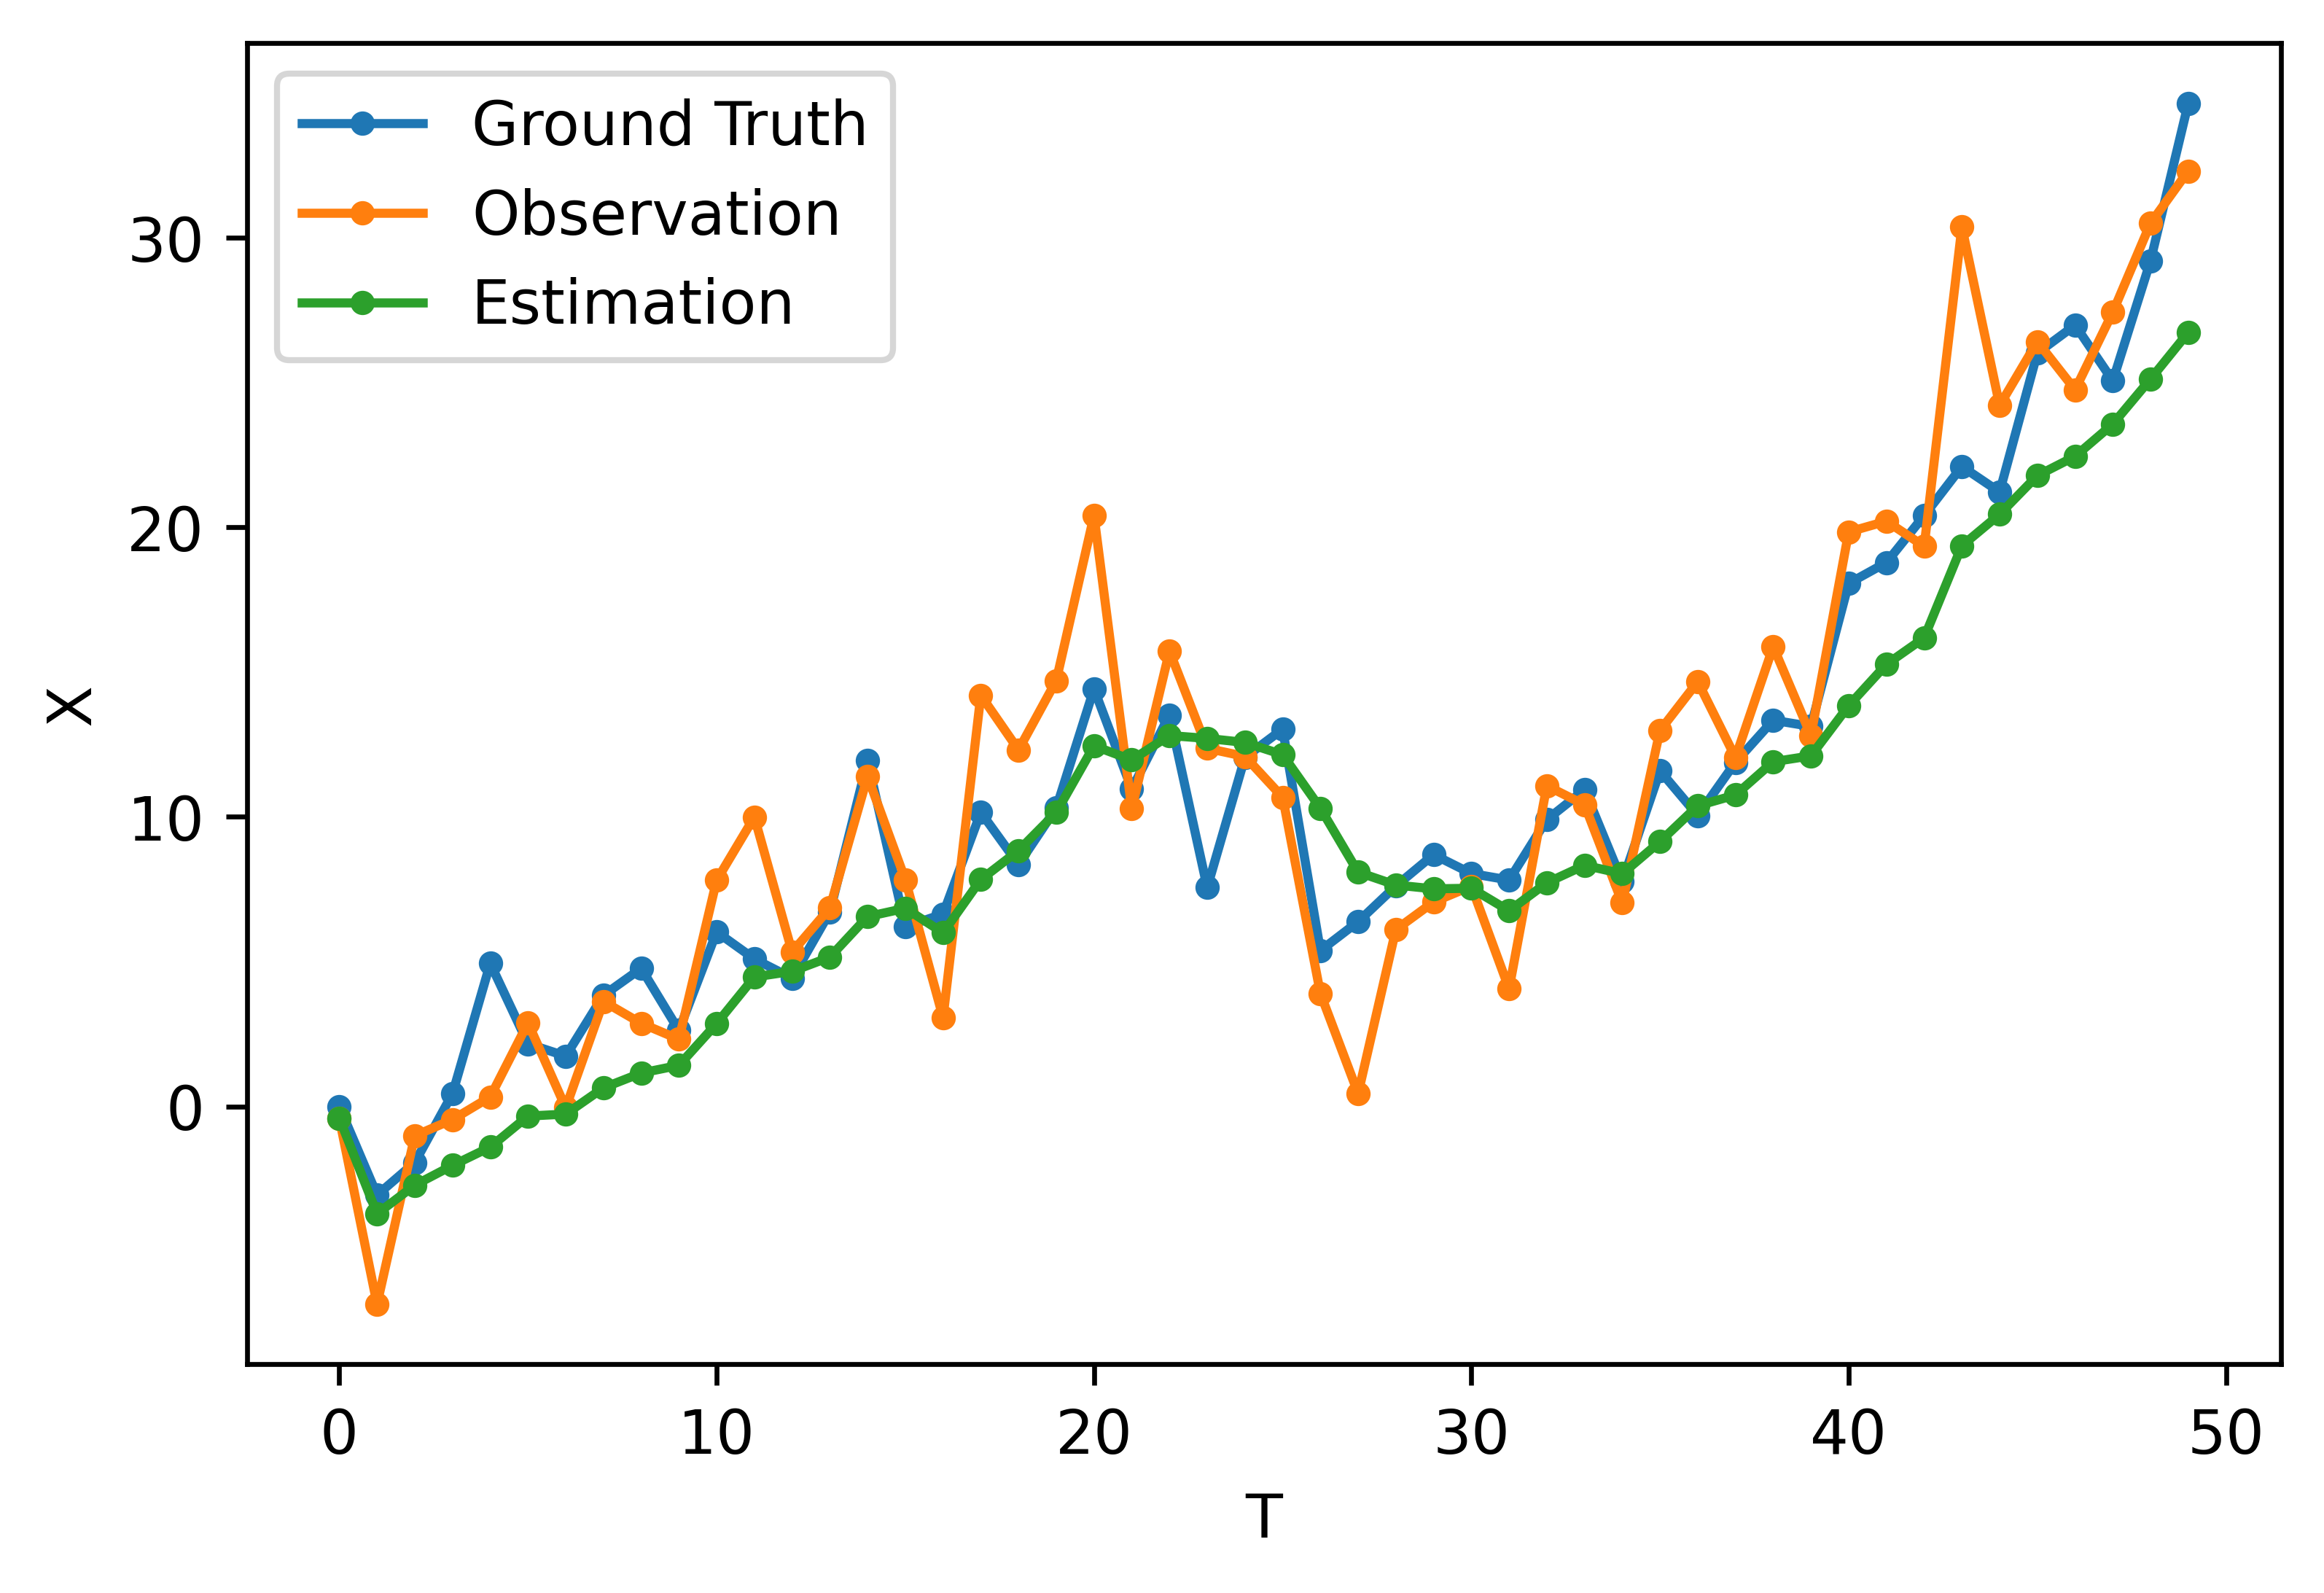

In [7]:
fig = plt.figure(dpi=600)
plt.plot(gt_traj, marker='.', linestyle='-', label='Ground Truth')
plt.plot(obs_traj, marker='.', linestyle='-', label='Observation')
plt.plot(estimate_traj_mu.reshape(-1), marker='.', linestyle='-', label='Estimation')
plt.legend()
plt.xlabel('T');
plt.ylabel('X');